In [19]:
import torch
print("CUDA available?", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available? True
GPU count: 1
GPU name: Tesla T4


In [20]:
from fastai.vision.all import *
from fastai.metrics import error_rate
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
from fastai.metrics import accuracy


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/archive.zip'  # Adjust this path as needed
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [23]:
# Combine all labeled image folders under one root
combined_path = Path('/content/data/fruits')


Setting-up type transforms pipelines
Found 656 items
2 datasets of sizes 460,66
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/data/fruits/train/orange/Screen Shot 2018-06-13 at 12.03.17 AM.png
    applying PILBase.create gives
      PILImage mode=RGB size=480x418
  Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/data/fruits/train/orange/Screen Shot 2018-06-13 at 12.03.17 AM.png
    applying label_func gives
      orange
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(2)

Final sample: (PILImage mode=RGB size=480x418, TensorCategory(2))


Found 656 items
2 datasets of sizes 460,66
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na'

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.768582,0.135557,0.045455,0.954545,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.549105,0.036381,0.015152,0.984848,00:07


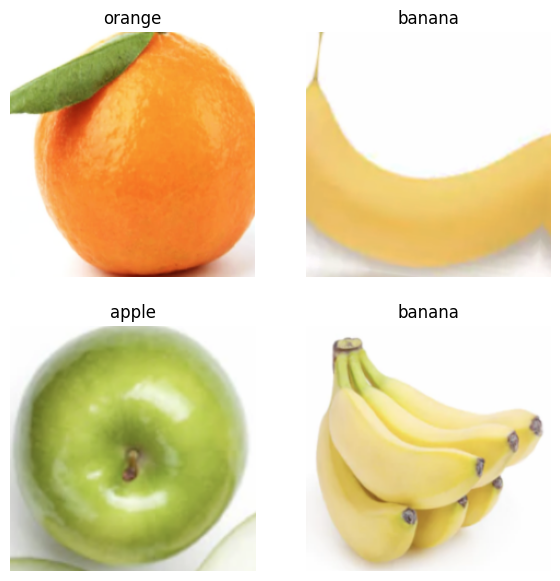

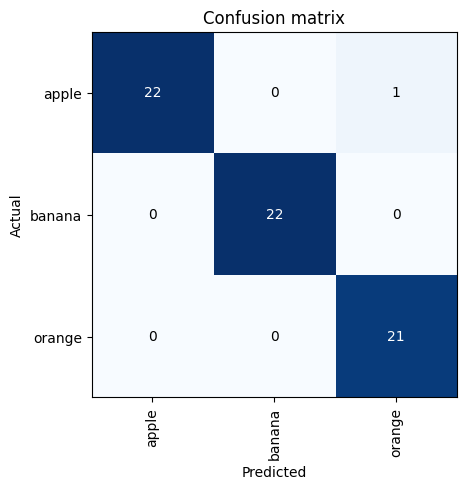

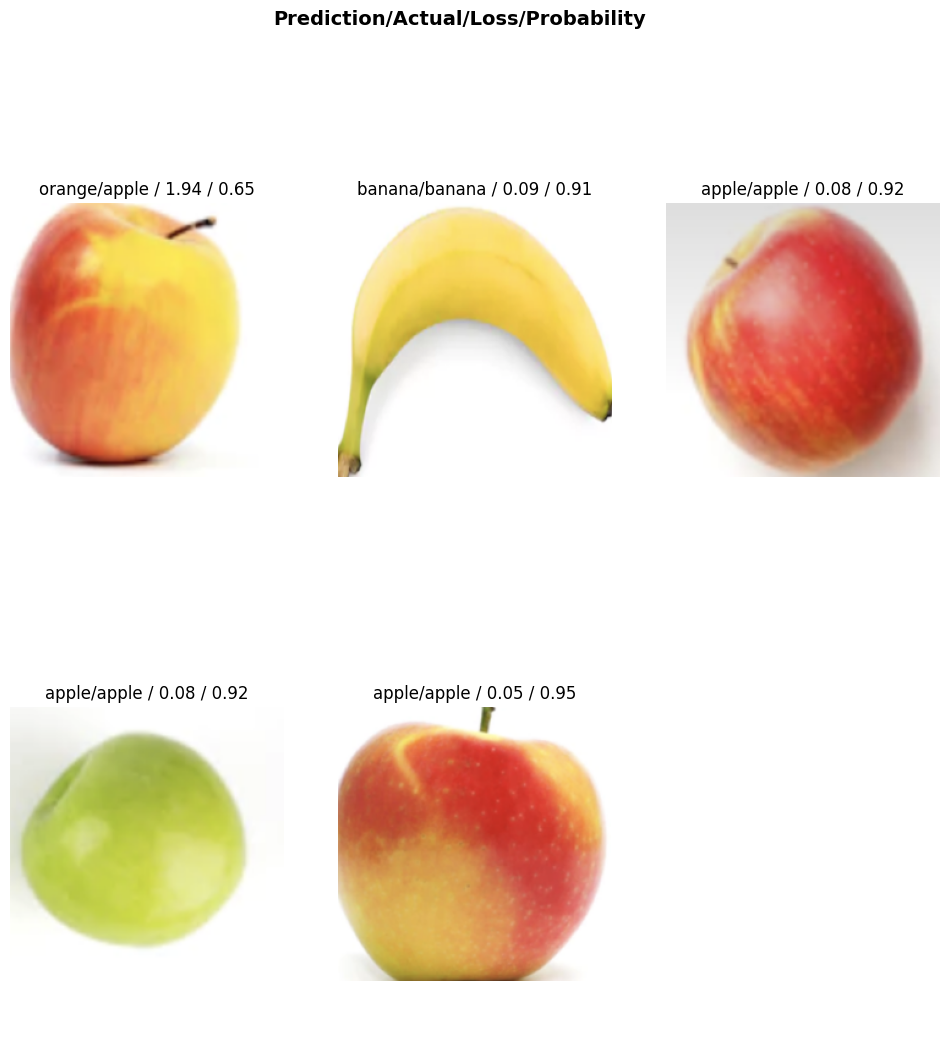

In [24]:


# Label comes from parent folder name (train/class1, validation/class2, etc.)
def label_func(f): return f.parent.name

# Transforms
item_tfms = [RandomResizedCrop(224, min_scale=0.5), FlipItem(0.5)]
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

# Create a DataBlock
fruits = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
    get_y=label_func,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

dls = fruits.dataloaders(combined_path, bs=4)


dls.show_batch(max_n=9, figsize=(7,7))

# Summary should be called on the DataBlock, not DataLoaders
fruits.summary(combined_path)

# A.4. Train a simple model (benchmark)
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(1)

# A.4.2 Interpret the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

losses = interp.top_losses(5)
interp.plot_top_losses(5, figsize=(12,12))

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Minimum/10:, Steepest point: SuggestedLRs(valley=0.002511886414140463)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.725282,1.287902,0.136364,0.863636,00:08
1,0.652141,1.520054,0.136364,0.863636,00:09
2,0.421378,0.993405,0.075758,0.924242,00:08
3,0.418609,1.125062,0.090909,0.909091,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.320013,3.392628,0.106061,0.893939,00:10
1,0.377704,1.010153,0.075758,0.924242,00:10
2,0.346829,2.021389,0.045455,0.954545,00:09
3,0.313868,1.417017,0.030303,0.969697,00:09
4,0.319689,2.909245,0.015152,0.984848,00:10


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.265450,nan,0.151515,0.848485,00:23
1,0.854491,nan,0.333333,0.666667,00:23
2,0.952682,nan,0.287879,0.712121,00:22


No test images found


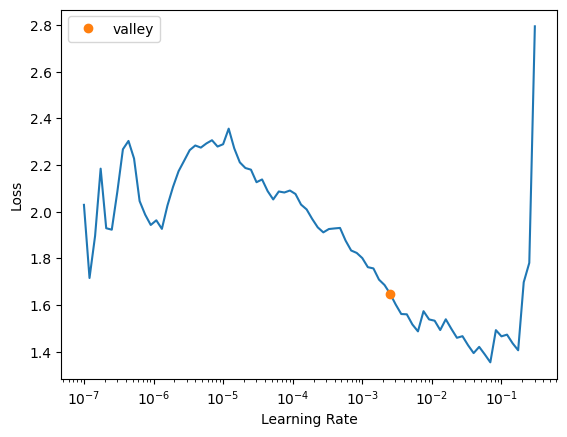

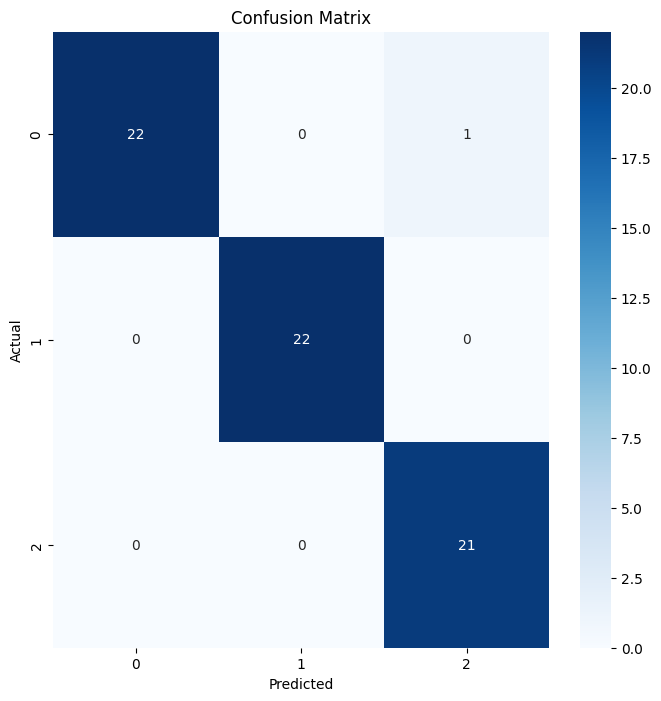

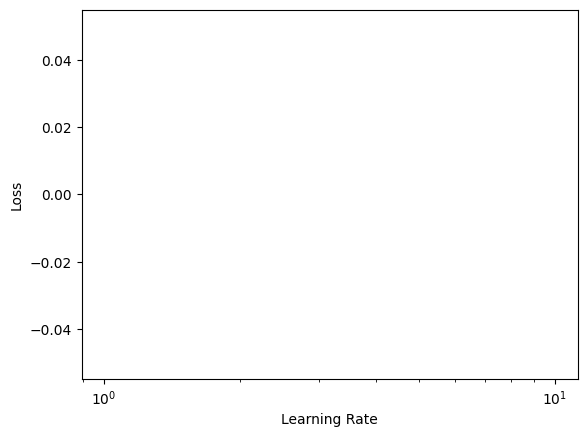

In [25]:
# B.1 & B.2 Learning Rate Finder
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
lr_steep = learn.lr_find()
print(f"Minimum/10:, Steepest point: {lr_steep}")

# B.3 Transfer Learning with Freezing/Unfreezing
learn = cnn_learner(dls, resnet50, metrics=[error_rate, accuracy])
learn.freeze()
learn.fit_one_cycle(4, 3e-3)

# B.3 Unfreezing and continue training
learn.unfreeze()

# B.4 Discriminative Learning Rates
learn.fit_one_cycle(5, slice(1e-5, 1e-3))

# B.6 Using a larger model with smaller batch size
dls_small = fruits.dataloaders(combined_path, bs=2)
learn_big = cnn_learner(dls_small, resnet101, metrics=error_rate)

# B.6.3 Using mixed precision
learn_big = cnn_learner(dls_small, resnet101, metrics=[error_rate, accuracy])
learn_big.to_fp16()
learn_big.fit_one_cycle(3, slice(1e-5, 1e-3))

# Save the model
learn.export('fruit_classifier.pkl')


# Ensure path exists before making prediction
test_images = list(combined_path.glob('test/*.jpg'))
if len(test_images) > 0:
    test_image = test_images[0]
    img = PILImage.create(test_image)
    pred_class, pred_idx, probs = learn.predict(img)
    print(f"Prediction: {pred_class}; Probability: {probs[pred_idx]:.4f}")
else:
    print("No test images found")

# Create a confusion matrix
preds,targets = learn.get_preds()
cm = confusion_matrix(targets, preds.argmax(dim=1))
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

# Plot learning rate vs loss from LR finder
learn.recorder.plot_lr_find()
plt.savefig('lr_finder.png')

# Implement presizing as described in section A.2.4
presizing_tfms = [RandomResizedCrop(450, min_scale=0.5), FlipItem(0.5)]
presizing_batch_tfms = [*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]

fruits_presized = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func,
    item_tfms=presizing_tfms,
    batch_tfms=presizing_batch_tfms
)

dls_presized = fruits_presized.dataloaders(combined_path, bs=4)


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.773391,0.154503,0.068702,0.931298,00:09


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.475575,0.128508,0.038168,0.961832,00:11
1,0.510052,0.057155,0.007634,0.992366,00:11
2,0.349525,0.070544,0.030534,0.969466,00:12


Text(0.5, 1.0, 'Confusion Matrix')

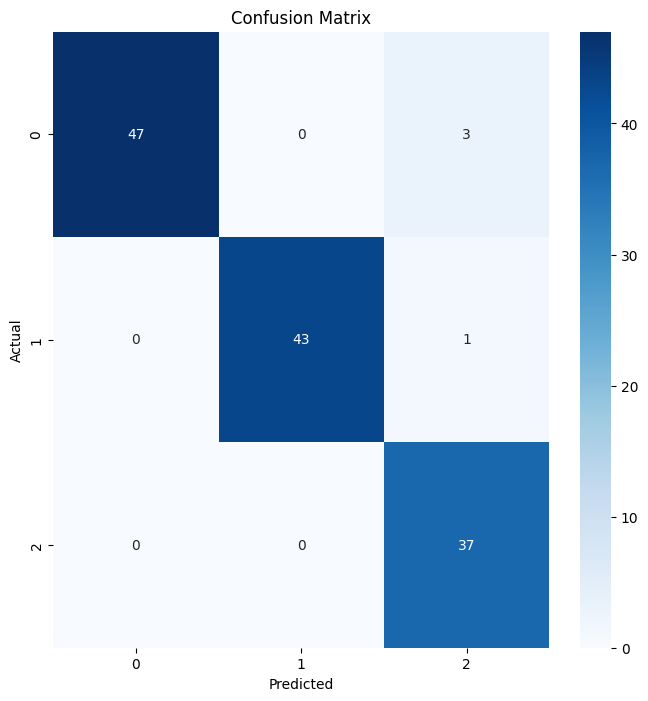

In [26]:
learn_presized = cnn_learner(dls_presized, resnet34, metrics=[error_rate, accuracy])
learn_presized.fine_tune(3, 1e-3)
# Create the confusion matrix
preds,targets = learn_presized.get_preds()
cm = confusion_matrix(targets, preds.argmax(dim=1))
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


In [27]:
from sklearn.metrics import accuracy_score

preds, targets = learn.get_preds()
acc = accuracy_score(targets, preds.argmax(dim=1))
print(f"Model Accuracy: {acc:.4f}")

Model Accuracy: 0.9848


In [28]:
preds, targets = learn_presized.get_preds()
acc = accuracy_score(targets, preds.argmax(dim=1))
print(f"Presized Model Accuracy: {acc:.4f}")

Presized Model Accuracy: 0.9695
